In [1]:
from pathlib import Path
import re, numpy as np, pandas as pd, mne
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [2]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

In [3]:
from src.feature_extraction import epochs_to_bandpower
from src.feature_extraction import reduce_features

In [4]:
DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

### Select which runs to extract epochs from

In [5]:
paths = sorted(DER.glob("*-epo.fif"))
# paths = [p for p in paths if re.search(r"R(03|04|07|08|11|12)", p.name)] # only these subjects have both L and R hand MI
# paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only
paths = [p for p in paths if re.search(r"R(03|07|11)", p.name)]  # L/R exec only
# paths = [p for p in paths if re.search(r"R(06|10|14)", p.name)]  # both imagery only

print("Files:", len(paths))


Files: 318


### Load epochs, extract bandpower features, and concatenate across all files

In [ ]:
X_all, y_all, runs, subjs = [], [], [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)
    if len(ep) == 0:
        # print(f"Skip (empty): {p.name}")
        continue

    X, y, chs, bns = epochs_to_bandpower(ep)
    m = re.search(r"R(\d{2})", p.name); run = int(m.group(1)) if m else -1; 
    subj_name = re.search(r"(S\d{3})", p.name).group(1) 
    subj_number = int(subj_name.lstrip("S"))
    X_all.append(X); y_all.append(y); runs.extend([run]*len(y)); subjs.extend([subj_number] * len(y))
    
X = np.vstack(X_all); y = np.concatenate(y_all); runs = np.array(runs)
print(
    f"X shape: {X.shape}\n"
    f"Y shape: {y.shape}\n"
    f"Runs shape: {runs.shape}\n"
    f"subjects shape: {len(subjs)}\n"
    f"Unique runs: {np.unique(runs)}\n"
    f"Unique labels: {np.unique(y)}\n"
    f"Unique subjects: {np.unique(subjs)}"
)


X shape: (1266, 256)
Y shape: (1266,)
Runs shape: (1266,)
subjects shape: 1266
Unique runs: [ 3  7 11]
Unique labels: [1 2]
Unique subjects: [  1   2   4   6   7   8  10  11  12  14  16  18  20  25  26  29  30  31
  33  34  35  37  40  41  42  44  45  47  50  51  55  57  59  62  63  64
  66  67  71  72  73  74  76  78  80  81  82  85  87  89  93  98 102 104
 105 107 108]


# Data exploration

In [7]:
# convert data to dataframe for easier handling
n_samples, n_features = X.shape
feature_names = [f"f{i+1}" for i in range(n_features)]
df_X = pd.DataFrame(X, columns=feature_names)
df_y = pd.DataFrame(y, columns=["label"])
df_runs = pd.DataFrame(runs, columns=["run"])
df_subjs = pd.DataFrame(subjs, columns=["subject"])
df = pd.concat([df_X, df_y, df_runs, df_subjs], axis=1)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f250,f251,f252,f253,f254,f255,f256,label,run,subject
0,-10.899988,-11.043146,-11.127990,-11.128700,-11.086014,-11.248554,-11.324826,-10.900050,-10.954291,-11.395118,...,-11.498937,-11.562839,-11.534085,-11.452269,-11.466645,-11.411654,-11.384385,1,7,1
1,-11.203984,-11.370694,-11.332728,-11.290575,-11.346758,-11.467783,-11.751206,-11.405654,-11.109273,-11.124177,...,-11.816257,-11.937613,-11.918060,-11.833467,-11.931678,-11.853158,-11.926145,1,3,2
2,-11.396883,-11.517307,-11.615792,-11.500148,-11.697128,-11.713902,-11.405218,-11.654353,-11.858030,-11.463409,...,-11.577680,-11.610825,-11.603847,-11.606789,-11.415285,-11.389378,-11.432619,1,3,2
3,-11.620116,-11.639113,-11.789570,-11.616954,-11.608464,-11.550864,-11.352737,-11.651074,-11.364287,-11.312846,...,-11.668317,-11.826642,-11.641616,-11.667768,-11.718213,-11.719671,-11.693196,2,3,2
4,-11.568807,-11.228480,-11.237295,-11.172238,-11.156028,-11.273518,-11.495918,-11.503444,-11.352284,-11.243346,...,-11.526648,-11.573623,-11.537369,-11.520725,-11.501939,-11.379961,-11.494487,2,7,2


### Class balance

label
2    0.504739
1    0.495261
Name: count, dtype: float64


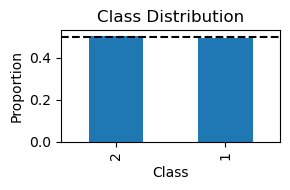

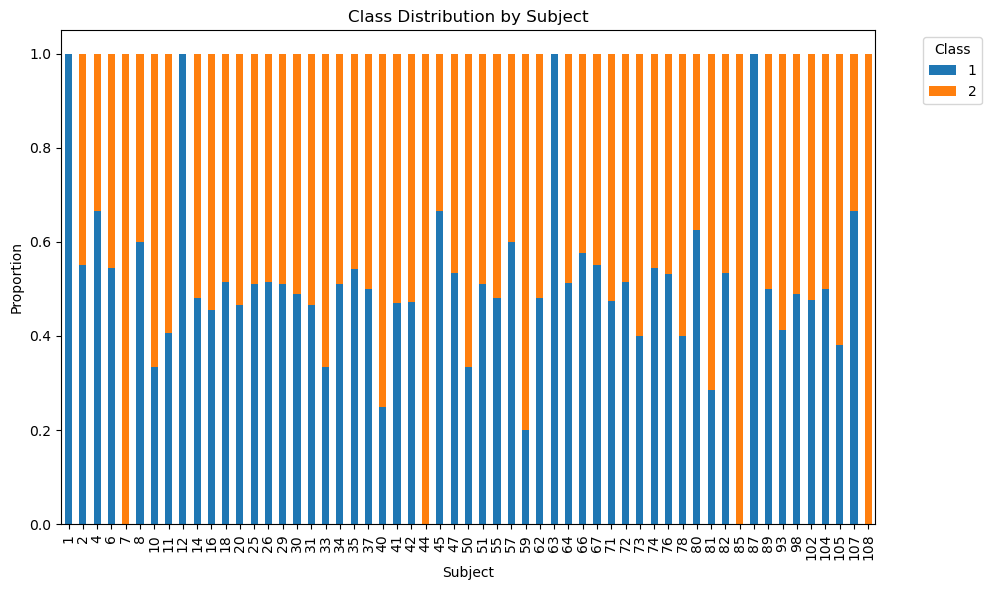

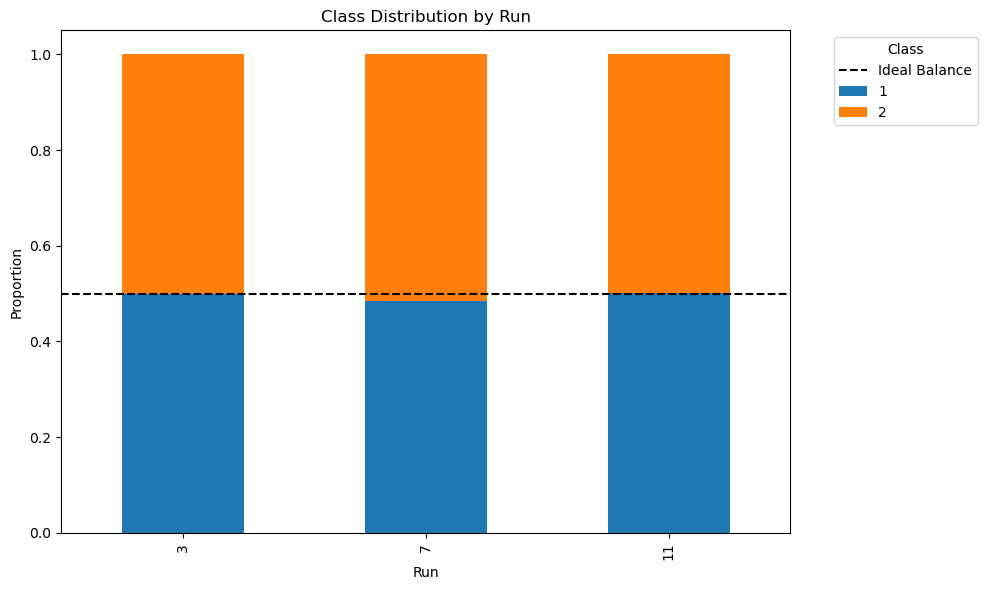

In [8]:
# check class balance
print(f"{df['label'].value_counts()/len(df)}")  
plt.figure(figsize=(3,2))
df['label'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution', ylabel='Proportion', xlabel='Class')
plt.axhline(0.5, color='black', linestyle='--', label='Ideal Balance')
plt.tight_layout()
plt.show()

# By subject class balance
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
df.groupby('subject')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax)
plt.title('Class Distribution by Subject')
plt.ylabel('Proportion')
plt.xlabel('Subject')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# By run class balance
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
df.groupby('run')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax)
plt.axhline(0.5, color='black', linestyle='--', label='Ideal Balance')
plt.title('Class Distribution by Run')
plt.ylabel('Proportion')
plt.xlabel('Run')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Per feature summary

In [9]:
# per feature summary
feature_summary = df_X.describe().T
feature_summary['range'] = feature_summary['max'] - feature_summary['min']
feature_summary = feature_summary[['min', 'max', 'range', 'mean', 'std', '25%', '50%', '75%']]
feature_summary.head()  

,min,max,range,mean,std,25%,50%,75%
f1,-11.983579,-10.359260,1.624319,-11.597192,0.308822,-11.843141,-11.684341,-11.420237
f2,-11.990699,-10.436001,1.554698,-11.646359,0.288128,-11.876685,-11.736005,-11.481707
f3,-11.992377,-10.420561,1.571816,-11.638352,0.305080,-11.881586,-11.743779,-11.464106
f4,-11.995044,-10.384126,1.610918,-11.630490,0.304439,-11.879690,-11.726138,-11.444309
f5,-11.993043,-10.467791,1.525252,-11.639470,0.297863,-11.878240,-11.733392,-11.460158


In [10]:
# outlier features - extremely high and low std values
print(df_X.std().sort_values().head(10))
print(df_X.std().sort_values().tail(10))

f219    0.092713
f212    0.094544
f213    0.094842
f243    0.095180
f244    0.096974
f245    0.098166
f211    0.098622
f208    0.099777
f242    0.100245
f241    0.102238
dtype: float64
f20    0.374513
f53    0.374605
f62    0.374750
f57    0.385718
f58    0.388653
f59    0.394434
f61    0.400680
f56    0.402917
f63    0.403268
f60    0.415319
dtype: float64


### Low-dimensional feature representation

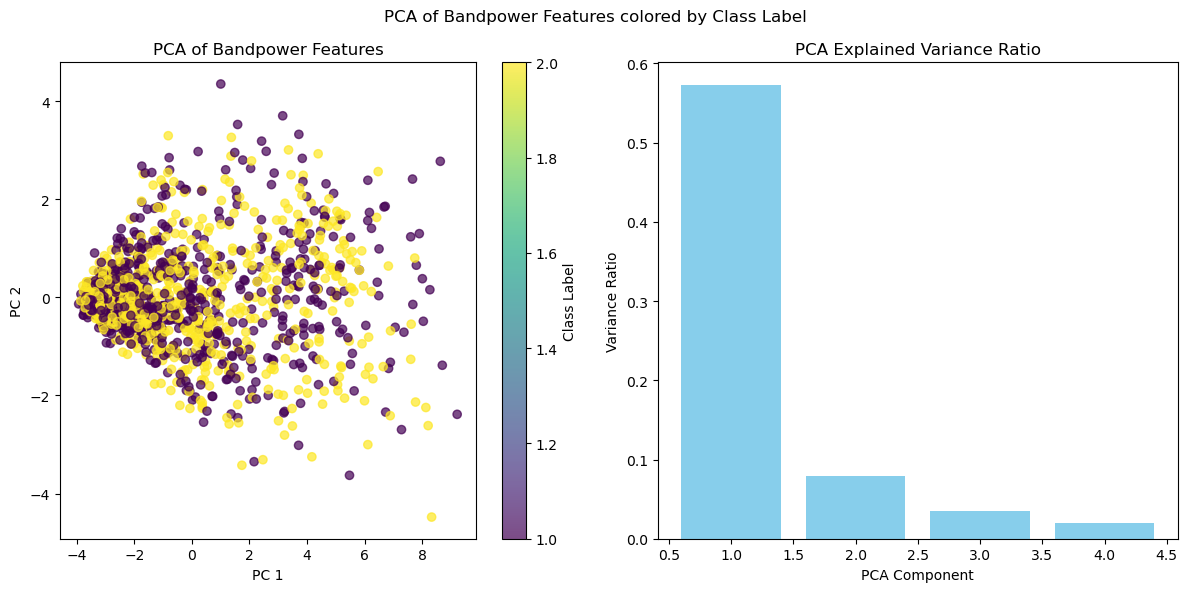

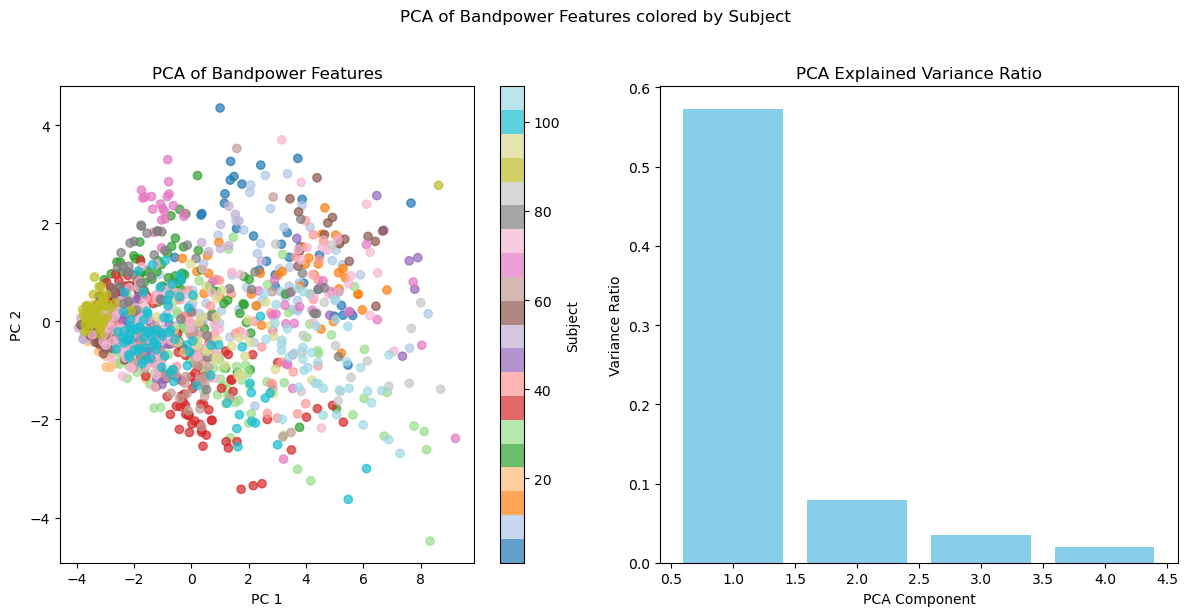

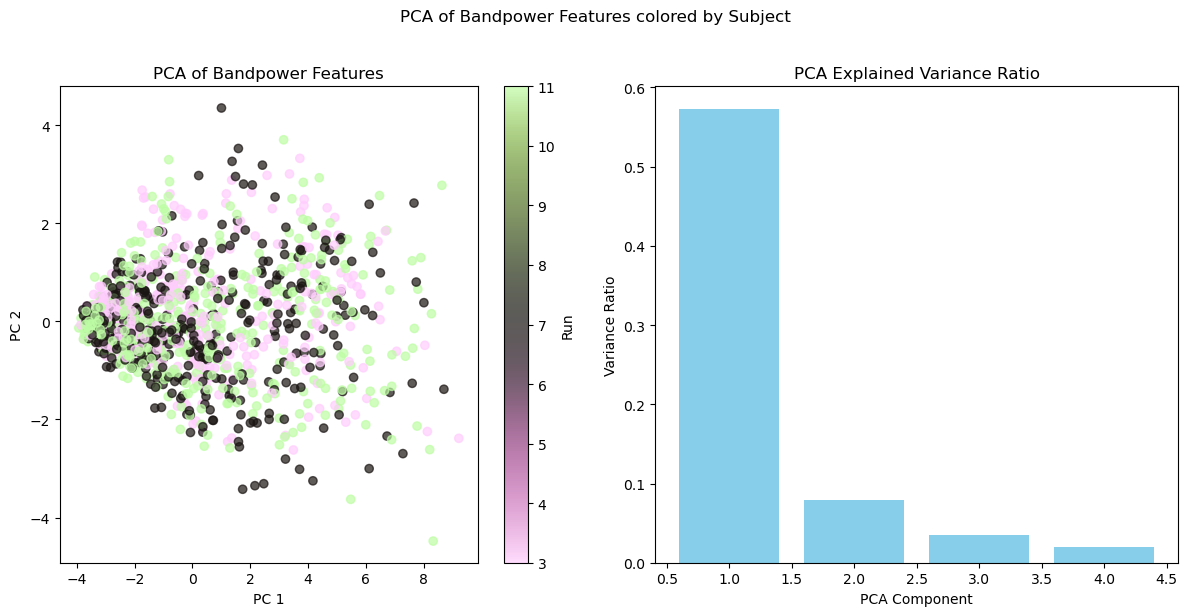

In [11]:
from sklearn.decomposition import PCA

### Low-dimensional feature representation
pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_X)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter = axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['label'], cmap='viridis', alpha=0.7)
axs[0].set_title('PCA of Bandpower Features')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
fig.colorbar(scatter, ax=axs[0], label='Class Label')

axs[1].bar(range(1, 5), pca.explained_variance_ratio_, color='skyblue')
axs[1].set_title('PCA Explained Variance Ratio')
axs[1].set_xlabel('PCA Component')
axs[1].set_ylabel('Variance Ratio')
plt.suptitle('PCA of Bandpower Features colored by Class Label')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter = axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['subject'], cmap='tab20', alpha=0.7)
axs[0].set_title('PCA of Bandpower Features')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
fig.colorbar(scatter, ax=axs[0], label='Subject')

axs[1].bar(range(1, 5), pca.explained_variance_ratio_, color='skyblue')
axs[1].set_title('PCA Explained Variance Ratio')
axs[1].set_xlabel('PCA Component')
axs[1].set_ylabel('Variance Ratio')
plt.suptitle('PCA of Bandpower Features colored by Subject', y=1.02)    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scatter = axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['run'], cmap='vanimo', alpha=0.7)
axs[0].set_title('PCA of Bandpower Features')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')
fig.colorbar(scatter, ax=axs[0], label='Run')

axs[1].bar(range(1, 5), pca.explained_variance_ratio_, color='skyblue')
axs[1].set_title('PCA Explained Variance Ratio')
axs[1].set_xlabel('PCA Component')
axs[1].set_ylabel('Variance Ratio')
plt.suptitle('PCA of Bandpower Features colored by Subject', y=1.02)    
plt.tight_layout()
plt.show()

### Supervised dimensionality reduction (LDA)

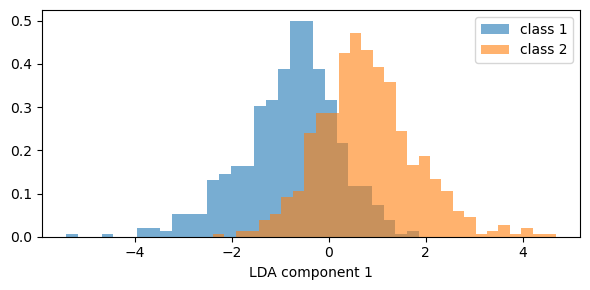

In [40]:
Z, mdl, info = reduce_features(X, y=y, method="lda", n_components=1) # supervised

plt.figure(figsize=(6,3))
for cls in np.unique(y):
    m = (y == cls)
    plt.hist(Z[m, 0], bins=30, alpha=0.6, label=f"class {cls}", density=True)
plt.xlabel("LDA component 1"); plt.legend(); plt.tight_layout()

# ML pipleine

In [12]:
groups = runs # could be runs or subjs here

In [13]:
print(
    f"X shape: {X.shape}\n"
    f"Y shape: {y.shape}\n"
    f"groups shape: {groups.shape}\n"
    f"Unique groups: {np.unique(groups)}\n"
    f"Unique labels: {np.unique(y)}\n"
)

X shape: (1266, 256)
Y shape: (1266,)
groups shape: (1266,)
Unique groups: [ 3  7 11]
Unique labels: [1 2]



### 1.1 Train-Test split

In [14]:
# Held out test split (group-aware)
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

In [15]:
np.unique(groups_train), np.unique(groups_test)

(array([ 7, 11]), array([3]))

### 1.2 CV strategy for model selection (group-aware)

In [16]:
# cv = GroupKFold(n_splits=5)
cv = LeaveOneGroupOut()

### 1.3 Make pipeline

In [17]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

### 1.4 Hyperparameter tuning on training data

In [18]:
param_grid = {
    "clf__C": [0.0001, 0.01, 0.1, 1, 10, 100],
    "clf__solver": ["lbfgs", "liblinear"],
    "clf__penalty": ["l2"]
}
### Hyperparameter tuning on training data
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train, groups=groups_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV score: 0.6612673604566218


### 1.5 Final eval on test set

In [19]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test set results:
Accuracy: 0.7387173396674585
Cohen's Kappa: 0.47752606164538114
F1-score: 0.7383852307136078
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.78      0.75       210
           2       0.76      0.70      0.73       211

    accuracy                           0.74       421
   macro avg       0.74      0.74      0.74       421
weighted avg       0.74      0.74      0.74       421



# Testing multiple ML models

### 2.4 Testing multiple models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Test logistic regression, lda, random forest, XGBoost, SVC
param_grid = [
    {
        'clf': [LogisticRegression(max_iter=2000, class_weight='balanced')],
        'clf__C': [0.01, 0.1, 1.0, 10],
        'clf__solver': ['lbfgs', 'liblinear']
    },
    {
        'clf': [LDA()],
        'clf__solver': ['svd', 'lsqr', 'eigen'] 
    },
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    },
    {
        'clf': [XGBClassifier()],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    },
    # {
    #     'clf': [SVC(class_weight='balanced')],
    #     'clf__C': [0.1, 1.0, 10.0],
    #     'clf__kernel': ['linear', 'rbf']
    
    # }
]

In [38]:
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1, refit=True)
grid.fit(X_train, y_train, groups=groups_train)
print("Best Model:", grid.best_estimator_.named_steps["clf"])
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 2 folds for each of 15 candidates, totalling 30 fits


/opt/conda/envs/neurodecode/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.58031235 0.58031235 0.58031235 0.61167469 0.64746174 0.63275646
 0.65302662 0.63381759 0.64039468        nan        nan        nan
        nan        nan        nan]
  warnings.warn(


Best Model: RandomForestClassifier(max_depth=10, n_estimators=200)
Best params: {'clf': RandomForestClassifier(), 'clf__max_depth': 10, 'clf__n_estimators': 200}
Best CV score: 0.653026617565835
Test set results:
Accuracy: 0.665083135391924
Cohen's Kappa: 0.33036650986497007
F1-score: 0.663800866536403
Classification Report:
               precision    recall  f1-score   support

           1       0.65      0.73      0.68       210
           2       0.69      0.60      0.64       211

    accuracy                           0.67       421
   macro avg       0.67      0.67      0.66       421
weighted avg       0.67      0.67      0.66       421



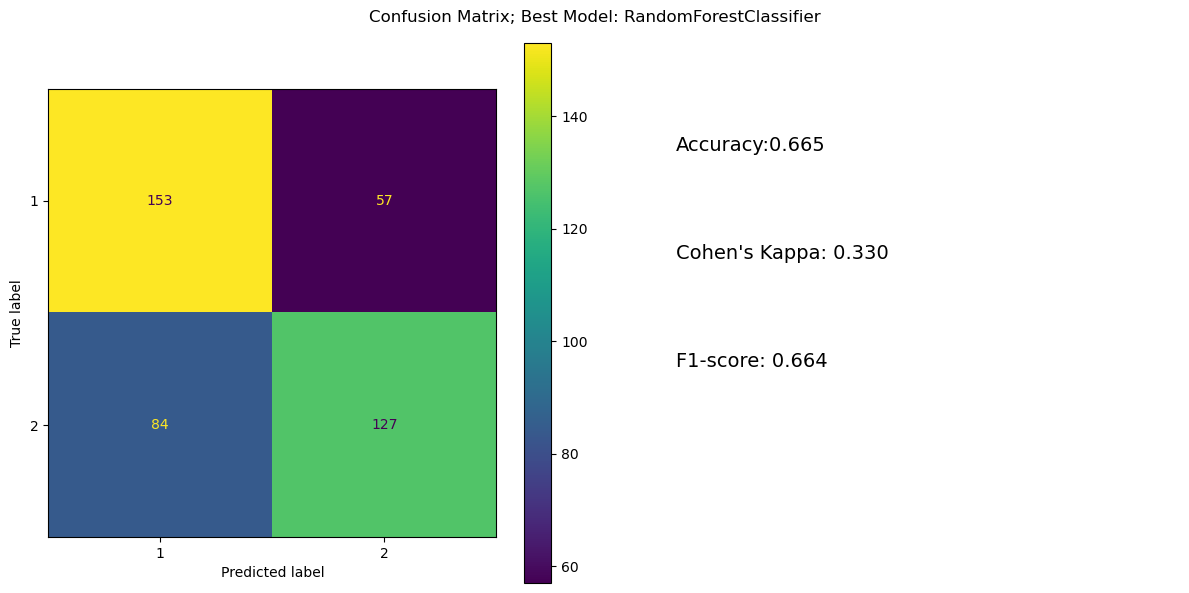

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(1,2, figsize=(12,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0])
plt.suptitle(f"Confusion Matrix; Best Model: {grid.best_estimator_.named_steps['clf'].__class__.__name__}")
# Print accuracies on the plot
acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
ax[1].text(0.1, 0.8, f"Accuracy:{acc:.3f}", fontsize=14)
ax[1].text(0.1, 0.6, f"Cohen's Kappa: {kappa:.3f}", fontsize=14)
ax[1].text(0.1, 0.4, f"F1-score: {f1:.3f}", fontsize=14)
ax[1].axis('off')
plt.tight_layout()
plt.savefig(f"{FIGS}/confusion_matrix_{grid.best_estimator_.named_steps['clf'].__class__.__name__}_bandpower.png")
plt.show()